In [1]:
%pip install --upgrade pandas-datareader
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from matplotlib import style
import datetime
import pandas_datareader.data as web
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima_model import ARIMA

In [3]:
import yfinance as yf
# Get the stock data using yfinance API:
# get 2009-2019 data to train our model
train_data = yf.download('BBCA.JK', start='2010-01-04', end='2019-12-01')

# get 2020 data to present date to test the SVM model
# test_data = yf.download('BBCA.JK', start='2020-01-02', end=datetime.date.today())
test_data = yf.download('BBCA.JK', start='2020-01-04', end='2021-12-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
train_data.columns = train_data.columns.droplevel(-1)
train_data

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2010-01-04,796.387695,1010.0,1010.0,965.0,1010.0,77812500
2010-01-05,804.272766,1020.0,1020.0,990.0,1020.0,44442500
2010-01-06,780.617737,990.0,1020.0,990.0,990.0,27782500
2010-01-07,784.560242,995.0,995.0,965.0,995.0,38632500
2010-01-08,764.847717,970.0,995.0,970.0,970.0,27427500
...,...,...,...,...,...,...
2019-11-25,5610.079590,6275.0,6335.0,6275.0,6330.0,55133500
2019-11-26,5619.020508,6285.0,6330.0,6270.0,6330.0,192783500
2019-11-27,5632.430176,6300.0,6300.0,6240.0,6270.0,58833500


In [5]:
test_data.columns = test_data.columns.droplevel(-1)
test_data

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-01-06,6040.391602,6735.0,6750.0,6690.0,6720.0,27300000
2020-01-07,6044.875977,6740.0,6770.0,6730.0,6735.0,45022500
2020-01-08,5991.063477,6680.0,6745.0,6670.0,6670.0,53692500
2020-01-09,6044.875977,6740.0,6755.0,6730.0,6740.0,40363500
2020-01-10,6031.422852,6725.0,6825.0,6710.0,6765.0,73362000
...,...,...,...,...,...,...
2021-11-24,6959.792969,7475.0,7575.0,7425.0,7575.0,35181400
2021-11-25,6913.239258,7425.0,7525.0,7425.0,7450.0,40216100
2021-11-26,6773.577637,7275.0,7450.0,7250.0,7400.0,113288400


In [6]:
# sort by date
train_data = train_data.sort_values('Date')
test_data = test_data.sort_values('Date')

# fix the date 
train_data.reset_index(inplace=True)
train_data.set_index("Date", inplace=True)
test_data.reset_index(inplace=True)
test_data.set_index("Date", inplace=True)

date_test = test_data.copy()
date_test = date_test.reset_index()

In [7]:
train_data

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2010-01-04,796.387695,1010.0,1010.0,965.0,1010.0,77812500
2010-01-05,804.272766,1020.0,1020.0,990.0,1020.0,44442500
2010-01-06,780.617737,990.0,1020.0,990.0,990.0,27782500
2010-01-07,784.560242,995.0,995.0,965.0,995.0,38632500
2010-01-08,764.847717,970.0,995.0,970.0,970.0,27427500
...,...,...,...,...,...,...
2019-11-25,5610.079590,6275.0,6335.0,6275.0,6330.0,55133500
2019-11-26,5619.020508,6285.0,6330.0,6270.0,6330.0,192783500
2019-11-27,5632.430176,6300.0,6300.0,6240.0,6270.0,58833500


In [8]:
test_data

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-01-06,6040.391602,6735.0,6750.0,6690.0,6720.0,27300000
2020-01-07,6044.875977,6740.0,6770.0,6730.0,6735.0,45022500
2020-01-08,5991.063477,6680.0,6745.0,6670.0,6670.0,53692500
2020-01-09,6044.875977,6740.0,6755.0,6730.0,6740.0,40363500
2020-01-10,6031.422852,6725.0,6825.0,6710.0,6765.0,73362000
...,...,...,...,...,...,...
2021-11-24,6959.792969,7475.0,7575.0,7425.0,7575.0,35181400
2021-11-25,6913.239258,7425.0,7525.0,7425.0,7450.0,40216100
2021-11-26,6773.577637,7275.0,7450.0,7250.0,7400.0,113288400


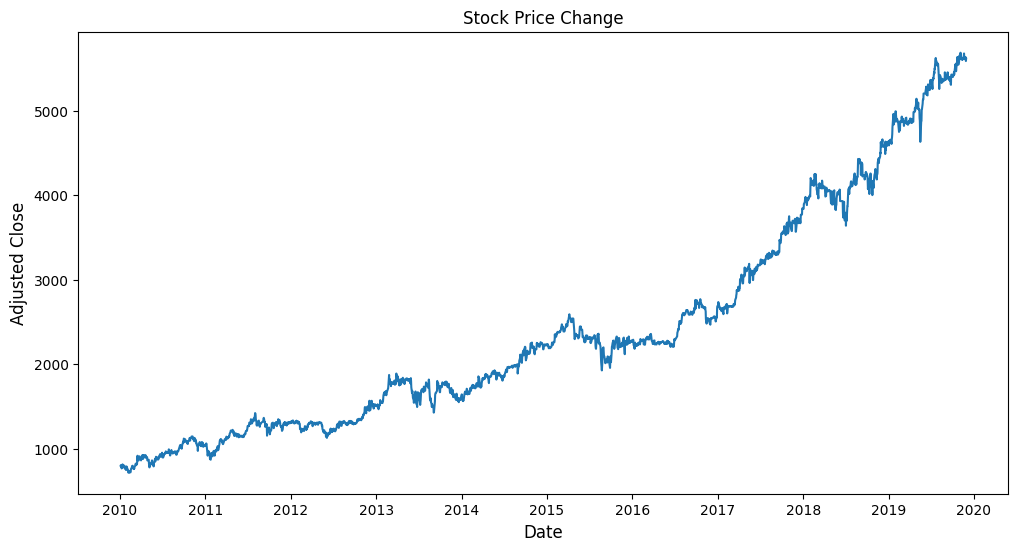

In [9]:
from matplotlib import pyplot as plt

#style.use('seaborn')
plt.figure(figsize = (12,6))
plt.plot(train_data["Adj Close"])
plt.title("Stock Price Change")
plt.xlabel("Date", fontsize = 12)
plt.ylabel("Adjusted Close", fontsize = 12)
plt.show()

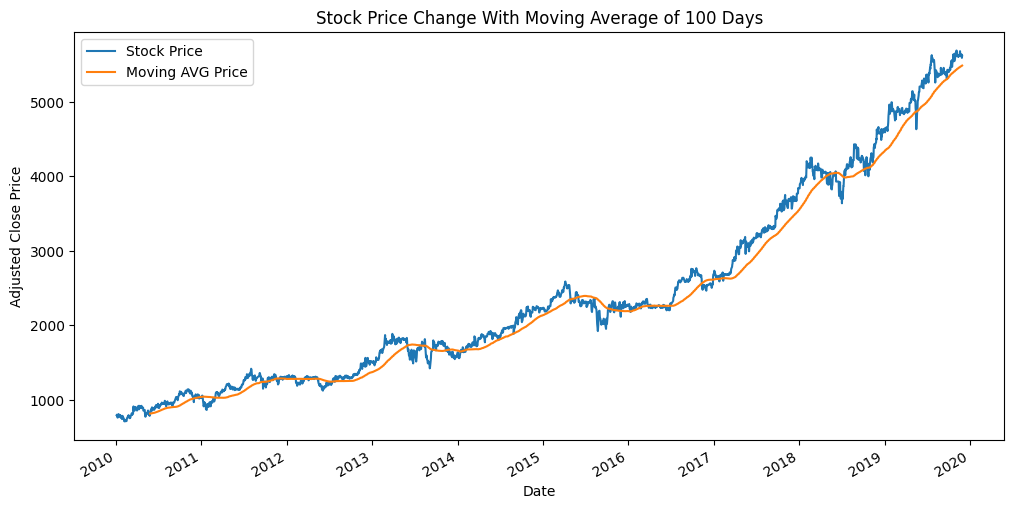

In [10]:
# Rolling mean
close_price = train_data['Adj Close']
moving_avg = close_price.rolling(window=100).mean()

plt.figure(figsize = (12,6))
plt.title("Stock Price Change With Moving Average of 100 Days")
close_price.plot(label='Stock Price')
moving_avg.plot(label='Moving AVG Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()

In [11]:

import matplotlib.dates as mdates

# change the dates into ints for training 
indxed_dates = train_data.copy()
indxed_dates = indxed_dates.reset_index()

# Store the original dates for plotting the predicitons
actual_dates = indxed_dates['Date']

# convert to ints
indxed_dates['Date'] = indxed_dates['Date'].map(mdates.date2num)

indxed_dates

Price,Date,Adj Close,Close,High,Low,Open,Volume
0,14613.0,796.387695,1010.0,1010.0,965.0,1010.0,77812500
1,14614.0,804.272766,1020.0,1020.0,990.0,1020.0,44442500
2,14615.0,780.617737,990.0,1020.0,990.0,990.0,27782500
3,14616.0,784.560242,995.0,995.0,965.0,995.0,38632500
4,14617.0,764.847717,970.0,995.0,970.0,970.0,27427500
...,...,...,...,...,...,...,...
2466,18225.0,5610.079590,6275.0,6335.0,6275.0,6330.0,55133500
2467,18226.0,5619.020508,6285.0,6330.0,6270.0,6330.0,192783500
2468,18227.0,5632.430176,6300.0,6300.0,6240.0,6270.0,58833500
2469,18228.0,5587.729492,6250.0,6295.0,6245.0,6295.0,44248000


In [12]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR

dates_data = indxed_dates['Date'].to_numpy()
prices_data = train_data['Adj Close'].to_numpy()

#Convert to 1d Vector
dates_data = np.reshape(dates_data, (len(dates_data), 1))
prices_data = np.reshape(prices_data, (len(prices_data), 1))

In [13]:
SVR_linear = make_pipeline(StandardScaler(), SVR(kernel='linear', C=1e4))
SVR_linear.fit(dates_data, prices_data)
SVR_linear_train = SVR_linear.predict(dates_data)

c:\Users\aryan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
SVR_linear_train

array([ 480.5019942 ,  481.51569397,  482.52939373, ..., 4144.01293694,
       4145.02663671, 4146.04033646])

In [15]:
SVR_rbfk = SVR(kernel= 'rbf', C= 1e4, gamma= 0.1)
SVR_rbfk.fit(dates_data, prices_data)
SVR_rbfk_train = SVR_rbfk.predict(dates_data)

c:\Users\aryan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
SVR_rbfk_train

array([ 796.48730454,  795.51848504,  794.85025876, ..., 5632.33085801,
       5652.17794712, 5614.44967113])

In [17]:
SVR_poly = make_pipeline(StandardScaler(), SVR(kernel='poly', C=1e3, degree=3, epsilon=0.1, coef0=1))
SVR_poly.fit(dates_data, prices_data)
SVR_poly_train = SVR_poly.predict(dates_data)

c:\Users\aryan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
SVR_poly_train

array([ 730.99381273,  732.11033634,  733.22573511, ..., 5766.06021076,
       5770.04150985, 5774.02552021])

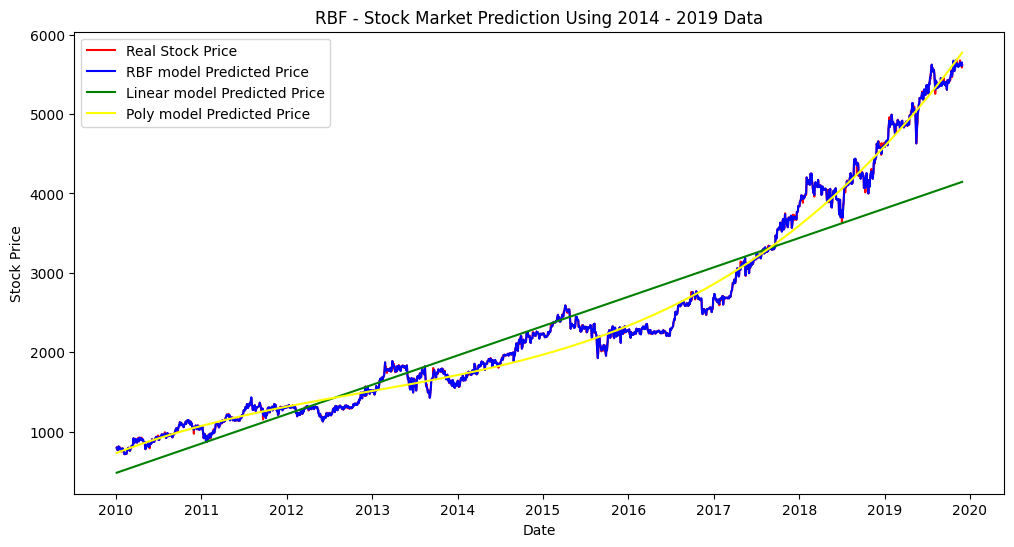

In [19]:
plt.figure(figsize = (12,6))
plt.title('RBF - Stock Market Prediction Using 2014 - 2019 Data')
plt.plot(dates_data, prices_data, color= 'red', label= 'Real Stock Price')
plt.plot(actual_dates, SVR_rbfk_train, color= 'blue', label= 'RBF model Predicted Price') 
plt.plot(actual_dates, SVR_linear_train, color= 'green', label= 'Linear model Predicted Price') 
plt.plot(actual_dates, SVR_poly_train, color= 'yellow', label= 'Poly model Predicted Price') 
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [20]:
# change the dates into ints for training 
test_indxed_dates = test_data.copy()
test_indxed_dates = test_indxed_dates.reset_index()

# Store the original dates for plotting the predicitons
test_actual_dates = test_indxed_dates['Date']

# convert to ints
test_indxed_dates['Date'] = test_indxed_dates['Date'].map(mdates.date2num)

In [21]:
test_indxed_dates

Price,Date,Adj Close,Close,High,Low,Open,Volume
0,18267.0,6040.391602,6735.0,6750.0,6690.0,6720.0,27300000
1,18268.0,6044.875977,6740.0,6770.0,6730.0,6735.0,45022500
2,18269.0,5991.063477,6680.0,6745.0,6670.0,6670.0,53692500
3,18270.0,6044.875977,6740.0,6755.0,6730.0,6740.0,40363500
4,18271.0,6031.422852,6725.0,6825.0,6710.0,6765.0,73362000
...,...,...,...,...,...,...,...
460,18955.0,6959.792969,7475.0,7575.0,7425.0,7575.0,35181400
461,18956.0,6913.239258,7425.0,7525.0,7425.0,7450.0,40216100
462,18957.0,6773.577637,7275.0,7450.0,7250.0,7400.0,113288400
463,18960.0,6889.962891,7400.0,7425.0,7175.0,7275.0,87907900


In [22]:
test_dates_data = test_indxed_dates['Date'].to_numpy()
test_prices_data = test_data['Adj Close'].to_numpy()

#Convert to 1d Vector
test_dates_data = np.reshape(test_dates_data, (len(test_dates_data), 1))
test_prices_data = np.reshape(test_prices_data, (len(test_prices_data), 1))

In [23]:
SVR_rbfk = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
SVR_rbfk.fit(test_dates_data, test_prices_data)
SVR_rbfk_test = SVR_rbfk.predict(test_dates_data)
SVR_rbfk_test

c:\Users\aryan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([6040.29184608, 6044.77590458, 6045.08838906, 6044.77594019,
       6031.52247242, 6049.46056558, 6098.04109507, 6129.97859976,
       6148.7113233 , 6165.85302623, 6129.97823607, 6125.69373673,
       6134.46107888, 6129.27309655, 6107.75636579, 6134.46117219,
       6134.90250483, 6085.13469808, 5969.36599625, 5811.79021035,
       5775.91594122, 5919.21350755, 6021.50861362, 6059.17981823,
       6062.71386167, 6085.13422736, 6102.28011823, 6098.58797489,
       6053.20595005, 5991.1631359 , 6026.83823038, 6021.90108443,
       5986.60698948, 5953.15668047, 5932.66658628, 5852.15037543,
       5808.15302338, 5757.97872895, 5705.38754767, 5641.1861294 ,
       5541.51540593, 5668.09251084, 5775.9160205 , 5742.21089306,
       5560.66749238, 5285.80418034, 5313.83010784, 5233.91536967,
       5078.99976464, 4986.67437353, 4986.47398402, 4747.82626693,
       4484.42940679, 4321.13034073, 4246.55950221, 3973.21603309,
       4100.30582119, 4735.35099347, 4941.83129975, 4976.17532

In [24]:
SVR_linear = make_pipeline(StandardScaler(), SVR(kernel='linear', C=1))
SVR_linear.fit(test_dates_data, test_prices_data)
SVR_linear_test =  SVR_linear.predict(test_dates_data)
SVR_linear_test

c:\Users\aryan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([5626.51920371, 5627.14255759, 5627.76591147, 5628.38926535,
       5629.01261923, 5630.88268086, 5631.50603474, 5632.12938862,
       5632.7527425 , 5633.37609637, 5635.24615801, 5635.86951189,
       5636.49286577, 5637.11621964, 5637.73957352, 5639.60963516,
       5640.23298904, 5640.85634291, 5641.47969679, 5642.10305067,
       5643.97311231, 5644.59646618, 5645.21982006, 5645.84317394,
       5646.46652782, 5648.33658945, 5648.95994333, 5649.58329721,
       5650.20665109, 5650.83000497, 5652.7000666 , 5653.32342048,
       5653.94677436, 5654.57012824, 5655.19348212, 5657.06354375,
       5657.68689763, 5658.31025151, 5658.93360539, 5659.55695926,
       5661.4270209 , 5662.05037478, 5662.67372865, 5663.29708253,
       5663.92043641, 5665.79049805, 5666.41385192, 5667.0372058 ,
       5667.66055968, 5668.28391356, 5670.15397519, 5670.77732907,
       5671.40068295, 5672.02403683, 5672.64739071, 5674.51745234,
       5675.14080622, 5676.38751398, 5677.01086786, 5678.88092

In [25]:
SVR_poly = make_pipeline(StandardScaler(), SVR(kernel='poly', C=1e3, degree=4, epsilon=0.1, coef0=1))
SVR_poly.fit(test_dates_data, test_prices_data)
SVR_poly_test = SVR_poly.predict(test_dates_data)
SVR_poly_test

c:\Users\aryan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([6535.315562  , 6503.7929073 , 6472.67845355, 6441.96951673,
       6411.66342052, 6323.1355276 , 6294.41418433, 6266.08241536,
       6238.13759049, 6210.57708723, 6130.17539729, 6104.12610912,
       6078.44814535, 6053.13892959, 6028.19589315, 5955.53828827,
       5932.03443603, 5908.88403502, 5886.08456266, 5863.63350408,
       5798.34577775, 5777.26337942, 5756.51693586, 5736.10397834,
       5716.0220458 , 5657.73790294, 5638.95561363, 5620.49215938,
       5602.34512527, 5584.51210409, 5532.87316106, 5516.27227301,
       5499.97347706, 5483.9744121 , 5468.27272472, 5422.92850931,
       5408.39295193, 5394.1431204 , 5380.17670745, 5366.49141349,
       5327.09936491, 5314.51570473, 5302.20178091, 5290.15533998,
       5278.37413617, 5244.59960506, 5233.85704577, 5223.36861007,
       5213.13209831, 5203.14531854, 5174.66156697, 5165.6519494 ,
       5156.88121938, 5148.34723109, 5140.04784639, 5116.53604786,
       5109.15384998, 5095.05944696, 5088.34306551, 5069.49230

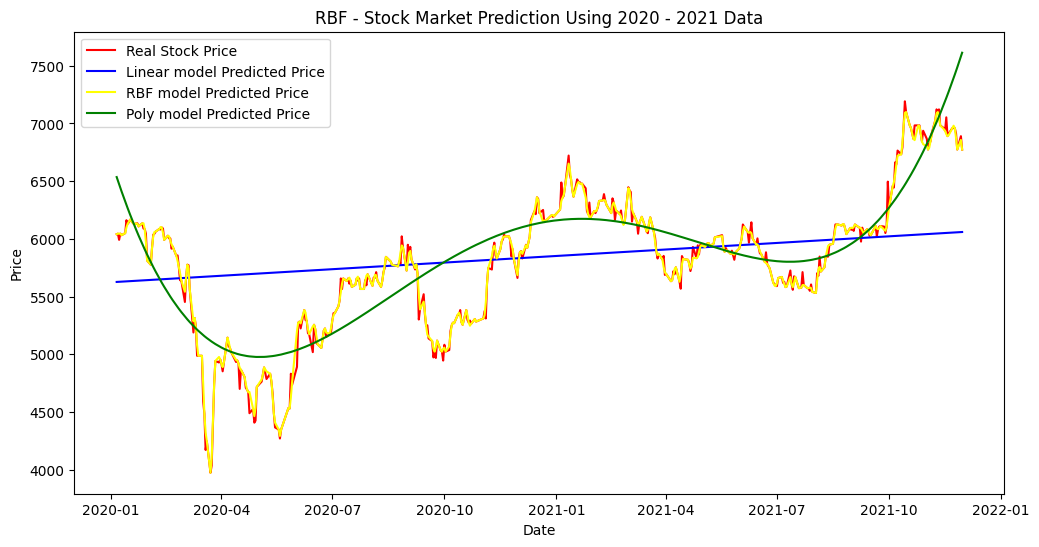

In [26]:
plt.figure(figsize = (12,6))
plt.title('RBF - Stock Market Prediction Using 2020 - 2021 Data')
plt.plot(test_dates_data, test_prices_data, color= 'red', label= 'Real Stock Price')
plt.plot(test_actual_dates, SVR_linear_test, color= 'blue', label= 'Linear model Predicted Price')
plt.plot(test_actual_dates, SVR_rbfk_test, color= 'yellow', label= 'RBF model Predicted Price')
plt.plot(test_actual_dates, SVR_poly_test, color= 'green', label= 'Poly model Predicted Price') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("SVR RBF Train RMSE: %.2f"
      % np.sqrt(mean_squared_error(prices_data, SVR_rbfk_train)))

print("SVR RBF Train R2 Score: %.2f"
      % r2_score(prices_data, SVR_rbfk_train))

print("SVR RBF Train MAE Score: %.2f"
      % mean_absolute_error(prices_data, SVR_rbfk_train))

print("SVR RBF Test RMSE: %.2f"
      % np.sqrt(mean_squared_error(test_prices_data, SVR_rbfk_test)))

print("SVR RBF Test R2 Score: %.2f"
      % r2_score(test_prices_data, SVR_rbfk_test))

print("SVR RBF Test MAE Score: %.2f"
      % mean_absolute_error(test_prices_data, SVR_rbfk_test))

SVR RBF Train RMSE: 11.94
SVR RBF Train R2 Score: 1.00
SVR RBF Train MAE Score: 3.92
SVR RBF Test RMSE: 48.46
SVR RBF Test R2 Score: 0.99
SVR RBF Test MAE Score: 23.02


In [28]:
print("SVR Linear Train RMSE: %.2f"
      % np.sqrt(mean_squared_error(prices_data, SVR_linear_train)))

print("SVR Linear Train R2 Score: %.2f"
      % r2_score(prices_data, SVR_linear_train))

print("SVR Linear Train MAE Score: %.2f"
      % mean_absolute_error(prices_data, SVR_linear_train))

print("SVR Linear Test RMSE: %.2f"
      % np.sqrt(mean_squared_error(test_prices_data, SVR_linear_test)))

print("SVR Linear Test R2 Score: %.2f"
      % r2_score(test_prices_data, SVR_linear_test))

print("SVR Linear Test MAE Score: %.2f"
      % mean_absolute_error(test_prices_data, SVR_linear_test))

SVR Linear Train RMSE: 483.91
SVR Linear Train R2 Score: 0.86
SVR Linear Train MAE Score: 350.79
SVR Linear Test RMSE: 529.38
SVR Linear Test R2 Score: 0.21
SVR Linear Test MAE Score: 408.91


In [29]:
print("SVR Poly Train RMSE: %.2f"
      % np.sqrt(mean_squared_error(prices_data, SVR_poly_train)))

print("SVR Poly Train R2 Score: %.2f"
      % r2_score(prices_data, SVR_poly_train))

print("SVR Poly Train MAE Score: %.2f"
      % mean_absolute_error(prices_data, SVR_poly_train))

print("SVR Poly Test RMSE: %.2f"
      % np.sqrt(mean_squared_error(test_prices_data, SVR_poly_test)))

print("SVR Poly Test R2 Score: %.2f"
      % r2_score(test_prices_data, SVR_poly_test))

print("SVR Poly Test MAE Score: %.2f"
      % mean_absolute_error(test_prices_data, SVR_poly_test))

SVR Poly Train RMSE: 160.79
SVR Poly Train R2 Score: 0.99
SVR Poly Train MAE Score: 121.65
SVR Poly Test RMSE: 315.42
SVR Poly Test R2 Score: 0.72
SVR Poly Test MAE Score: 241.83


In [30]:
test_data['Adj Close'].values

array([6040.39160156, 6044.87597656, 5991.06347656, 6044.87597656,
       6031.42285156, 6049.36035156, 6161.46875   , 6130.07861328,
       6143.53125   , 6165.95263672, 6130.07861328, 6125.59375   ,
       6134.56152344, 6134.56152344, 6107.65625   , 6134.56152344,
       6089.71923828, 6085.234375  , 6044.87597656, 5811.69042969,
       5775.81591797, 5919.31396484, 6035.90722656, 6044.87597656,
       6062.81347656, 6085.234375  , 6080.75048828, 6098.6875    ,
       6089.71923828, 5991.06347656, 6026.93798828, 6004.51611328,
       6004.51611328, 5914.83007812, 5932.76660156, 5852.05029297,
       5856.53417969, 5757.87890625, 5641.28564453, 5641.28564453,
       5452.94482422, 5668.19287109, 5775.81591797, 5771.33203125,
       5560.56787109, 5188.36816406, 5313.9296875 , 5246.66455078,
       4986.57421875, 4986.57421875, 4986.57421875, 4591.95263672,
       4484.32910156, 4170.42626953, 4246.65966797, 3973.11572266,
       4035.89599609, 4735.45117188, 4941.73095703, 4928.27734

In [31]:
training_data = train_data['Adj Close'].values
test_data = test_data['Adj Close'].values

h = [x for x in training_data]
pred = []
total_test = len(test_data)

for time_point in range(total_test):
    model = ARIMA(h, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    
    pred.append(yhat)
    true_test_value = test_data[time_point]
    h.append(true_test_value)

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


ValueError: x and y must have same first dimension, but have shapes (465,) and (0,)

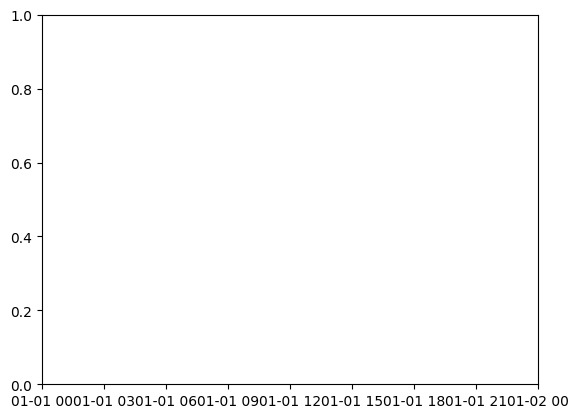

In [ ]:
plt.plot(date_test["Date"], pred, color='blue',label='Predicted')
plt.plot(date_test["Date"], test_data, color='red', label='Actual')
plt.title('Stock Market Prediction Using 2020 - 2021 Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score

x = np.concatenate(pred, axis=0 )
r2_score(test_data, x)